# Multi-component phase equilibrium

We can use Raolt's Law to capture the behavior of a liquid-vapor mixture of propane and n-butane, at a mixture pressure of 2 atm. 

For each component $i$,
\begin{equation}
x_{f,i} P_{\text{sat}, i} = x_i P \;,
\end{equation}
where $x_i$ is the mole fraction of component $i$ in the gas phase, $x_{f,i}$ is the mole fraction of component $i$ in the liquid phase, $P$ is the mixture pressure, and $P_{\text{sat}, i}$ is the saturation pressure of component $i$ at the mixture temperature.

First, given a mixture with equal mole fractions of propane and n-butane in the liquid phase (0.5 and 0.5), find the equilibrium temperature and the gas-phase mole fractions:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# these are mostly for making the saved figures nicer
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 150
plt.rcParams['savefig.dpi'] = 150

import numpy as np
from scipy.optimize import root
from CoolProp.CoolProp import PropsSI

from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

Specify the known data:

In [2]:
pressure = Q_(2, 'atm')
components = ['propane', 'butane']

mole_fraction_liquid = np.zeros(2)
mole_fraction_liquid[0] = 0.5
mole_fraction_liquid[1] = 1.0 - mole_fraction_liquid[0]

We then write a function for the system of equations we need to solve to find our unknowns: the equilibrium temperature, and the two mole fractions of the components in the vapor phase. So, we need three equations:

$$
x_1 + x_2 = 1 \\
x_{f,1} P_{\text{sat}, 1} = x_1 P \\
x_{f,2} P_{\text{sat}, 2} = x_2 P \;,
$$

which come from conservation of mass and Raoult's Law.

We'll use the `root()` function, which finds the values of our unknowns that make our equations equal to zero (i.e., the roots). To use this, we need to make our equations all equal zero, such that the correct values of the unknowns satisfy them:

$$
x_1 + x_2 - 1 = 0 \\
x_{f,1} P_{\text{sat}, 1} - x_1 P = 0 \\
x_{f,2} P_{\text{sat}, 2} - x_2 P = 0
$$

Now, we can define the function, then solve for the roots:

In [3]:
def equilibrium(xvals, pressure, components, mole_fraction_liquid):
    '''Function for finding equilibrium temperature and vapor mole fractions.
    
    xvals[0]: temperature (K)
    xvals[1:]: vapor mole fractions
    '''
    temp = xvals[0]
    mole_fraction_gas = [xvals[1], xvals[2]]
    
    pressure_sat = np.zeros(2)
    pressure_sat[0] = PropsSI('P', 'T', temp, 'Q', 1.0, components[0])
    pressure_sat[1] = PropsSI('P', 'T', temp, 'Q', 1.0, components[1])
    
    return [
        (mole_fraction_liquid[0] * pressure_sat[0] - 
         mole_fraction_gas[0] * pressure
         ),
        (mole_fraction_liquid[1] * pressure_sat[1] - 
         mole_fraction_gas[1] * pressure
         ),
        mole_fraction_gas[0] + mole_fraction_gas[1] - 1.0
    ]

In [4]:
sol = root(
    equilibrium, [250, 0.5, 0.5],
    args=(pressure.to('Pa').magnitude, components, mole_fraction_liquid,)
    )

print(f'Equilibrium temperature: {sol.x[0]: .2f} K')
print(f'Gas mole fraction of {components[0]}: {sol.x[1]: .3f}')
print(f'Gas mole fraction of {components[1]}: {sol.x[2]: .3f}')

Equilibrium temperature:  262.48 K
Gas mole fraction of propane:  0.833
Gas mole fraction of butane:  0.167


We see that though the we have equal moles of the components in the liquid phase, the mole fraction of propane is over 80% in the vapor phase.

We can use the same approach to show the relationship between liquid and gas mole fraction for the two components:

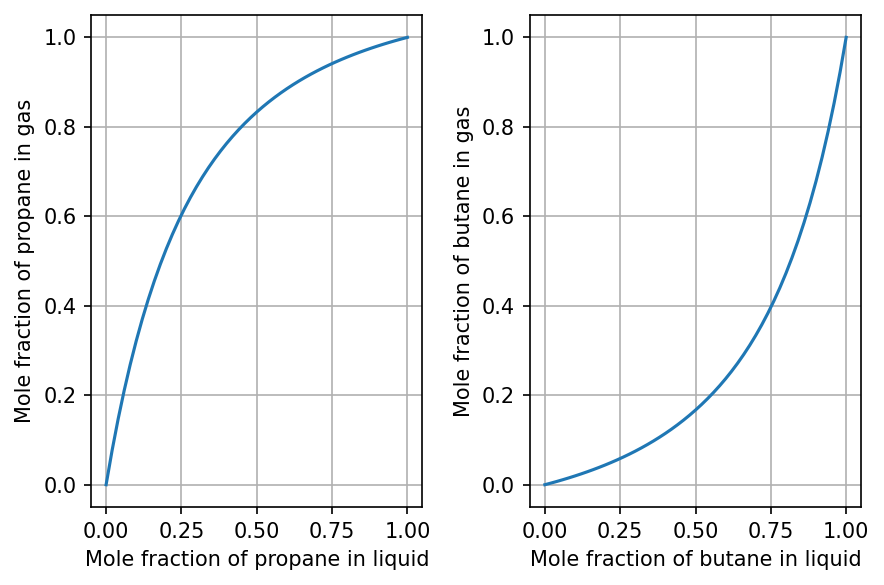

In [5]:
# since we just have two components and the mole 
# fractions must sum to 1.0, we can just create
# a single array for the first component
mole_fractions_liquid = np.linspace(0, 1, 51)

temps = np.zeros(len(mole_fractions_liquid))
mole_fractions_gas = np.zeros((len(mole_fractions_liquid), 2))

for idx, x in enumerate(mole_fractions_liquid):
    sol = root(
        equilibrium, [250, 0.5, 0.5],
        args=(pressure.to('Pa').magnitude, components, [x, 1.0 - x],)
        )
    temps[idx] = sol.x[0]
    mole_fractions_gas[idx] = [sol.x[1], sol.x[2]]

fig, ax = plt.subplots(1, 2)

ax[0].plot(mole_fractions_liquid, mole_fractions_gas[:,0])
ax[0].set_xlabel(f'Mole fraction of {components[0]} in liquid')
ax[0].set_ylabel(f'Mole fraction of {components[0]} in gas')
ax[0].grid(True)

ax[1].plot(1.0 - mole_fractions_liquid, mole_fractions_gas[:,1])
ax[1].set_xlabel(f'Mole fraction of {components[1]} in liquid')
ax[1].set_ylabel(f'Mole fraction of {components[1]} in gas')
ax[1].grid(True)

plt.tight_layout()
plt.show()

The line between the liquid and gas mole fractions is the *equilibrium line*.

Interestingly, we see that the gas phase is richer in propane than the liquid phase, and the leaner in butane.

We can also plot the temperature against the propane mole fractions in the liquid and gas phases:

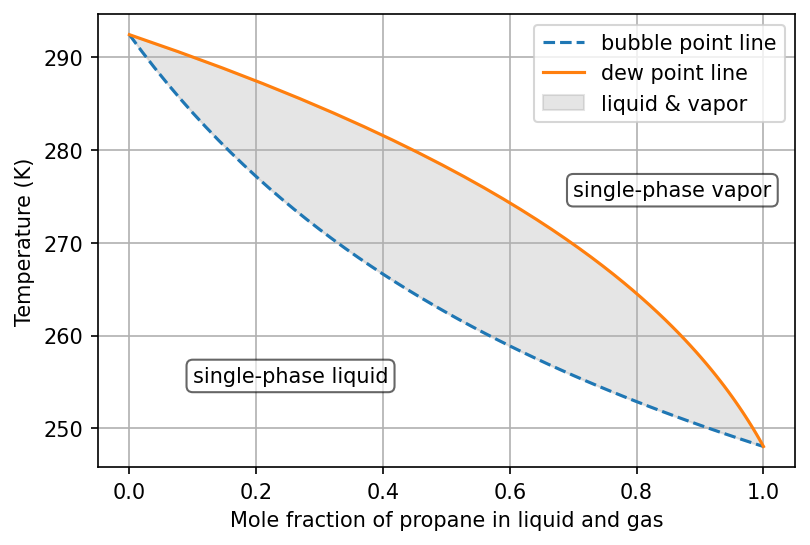

In [6]:
plt.plot(mole_fractions_liquid, temps, '--', label='bubble point line')
plt.plot(mole_fractions_gas[:,0], temps, label='dew point line')

# fill space between the lines
plt.fill_betweenx(
    temps, mole_fractions_liquid, mole_fractions_gas[:,0],
    color='gray', alpha=0.2, label='liquid & vapor'
    )

plt.xlabel('Mole fraction of propane in liquid and gas')
plt.ylabel('Temperature (K)')

# text box properties
props = dict(boxstyle='round', facecolor='white', alpha=0.6)

plt.text(0.1, 255, 'single-phase liquid', bbox=props)
plt.text(0.7, 275, 'single-phase vapor', bbox=props)

plt.grid(True)
plt.legend()
plt.show()

The line formed by the temperature and liquid mole fraction is the *bubble point line* and the line of temperature and vapor mole fraction is the *dew point line*.

The region between the lines shows the temperatures where the liquid and vapor phases can coexist; below the bubble point line, the mixture will always be in a liquid phase, and above the dew point line, the mixture will always in a vapor phase.

This plot can be used to examine the behavior of a two-phase mixture undergoing a heating process. For example, consider a mixture that starts at 250 K and a liquid mole fraction of propane of 0.6, as it is heated. Note that the total mole fraction of propane, 0.6, should remain constant through this process.

One useful quantity to calculate is the quality of mixture, the ratio of the moles of vapor to the total moles, can be found here using the information about propane:

$$
Q = \frac{n_g}{n} = \frac{n_g}{n_g + n_f} \\
Q = \frac{z_1 - x_1}{x_{f,1} - x_1} \;,
$$

where $z_1$ is the total mole fraction of propane ($n_1 / n$), which remains constant through this process.

1. Initially the mixture is entirely liquid, and the liquid mole fractions remain constant as the mixture is heated. 
2. With increasing temperature, eventually we reach the bubble point line, at a temperature of about 259 K. The first bubbles appear, with a propane mole fraction of 0.89 in the vapor phase found via the *tie line* (the horizontal line connecting to the dew point line at this temperature).
3. As the mixture is heated more and the temperature increases, it forms a two-phase mixture. The liquid and vapor mole fractions of propane are found via the horizontal tie lines connecting to the bubble and dew point lines. For example, at about 265 K, the propane mole fractions are about 0.44 and 0.79 in the liquid and vapor phases, respectively. At this state, the quality is about 0.45.
4. Finally, with more heating, the temperature continues to rise until the mixture reaches the dew point line, where the quality is 1 and the mole fraction of propane in the vapor phase is 0.6. This occurs at about 274 K, and the last liquid droplet will have a propane mole fraction of about 0.24.
5. Further heating will bring the mixture fully into the vapor phase, with a propane mole fraction of 0.6.

It also shows the *temperature glide*, which is the difference between the temperatures at the dew line and bubble line for a given composition.

The calculations for these values follow:

In [7]:
print('Point 2:')
print(f'Temperature: {temps[30]: .1f} K')
total_mole_fraction_propane = mole_fractions_liquid[30]
print(f'Mole fraction of propane in liquid phase: {mole_fractions_liquid[30]: .3f}')
print(f'Mole fraction of propane in the vapor phase: {mole_fractions_gas[30,0]: .3f}')

Point 2:
Temperature:  258.9 K
Mole fraction of propane in liquid phase:  0.600
Mole fraction of propane in the vapor phase:  0.885


In [8]:
print('Point 3:')
print(f'Temperature: {temps[22]: .1f} K')
print(f'Mole fraction of propane in liquid phase: {mole_fractions_liquid[22]: .3f}')
print(f'Mole fraction of propane in the vapor phase: {mole_fractions_gas[22,0]: .3f}')

quality_propane = (
    (total_mole_fraction_propane - mole_fractions_liquid[22]) /
    (mole_fractions_gas[22,0] - mole_fractions_liquid[22])
    )
print(f'Quality of propane: {quality_propane: .3f}')

Point 3:
Temperature:  264.9 K
Mole fraction of propane in liquid phase:  0.440
Mole fraction of propane in the vapor phase:  0.794
Quality of propane:  0.452


In [9]:
print('Point 4 (approximate):')
print(f'Temperature: {temps[12]: .1f} K')
print(f'Mole fraction of propane in liquid phase: {mole_fractions_liquid[12]: .3f}')
print(f'Mole fraction of propane in the vapor phase: {mole_fractions_gas[12,0]: .3f}')

Point 4 (approximate):
Temperature:  274.7 K
Mole fraction of propane in liquid phase:  0.240
Mole fraction of propane in the vapor phase:  0.589
